# Mask R-CNN for Bin Picking

This notebook is adopted from the [TorchVision 0.3 Object Detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).  We will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model on a dataset generated from our "clutter generator" script.


https://manipulation.csail.mit.edu/segmentation.html

In [1]:
# Imports
import fnmatch
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from PIL import Image

ycb = [
    "003_cracker_box.sdf",
    "004_sugar_box.sdf",
    "005_tomato_soup_can.sdf",
    "006_mustard_bottle.sdf",
    "009_gelatin_box.sdf",
    "010_potted_meat_can.sdf",
]

# Download our bin-picking model

And a small set of images for testing.

In [2]:
dataset_path = "clutter_maskrcnn_data"
if not os.path.exists(dataset_path):
    !wget https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_test.zip .
    !unzip -q clutter_maskrcnn_test.zip

num_images = len(fnmatch.filter(os.listdir(dataset_path), "*.png"))


def open_image(idx):
    filename = os.path.join(dataset_path, f"{idx:05d}.png")
    return Image.open(filename).convert("RGB")


model_file = "clutter_maskrcnn_model.pt"
if not os.path.exists(model_file):
    !wget https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_model.pt .

--2025-01-03 02:27:00--  https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_test.zip
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.52.131.233
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://locomotion.csail.mit.edu/clutter_maskrcnn_test.zip [following]
--2025-01-03 02:27:01--  https://locomotion.csail.mit.edu/clutter_maskrcnn_test.zip
Resolving locomotion.csail.mit.edu (locomotion.csail.mit.edu)... 128.52.131.233
Connecting to locomotion.csail.mit.edu (locomotion.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5280952 (5.0M) [application/zip]
Saving to: ‘clutter_maskrcnn_test.zip’

clutter_maskrcnn_te 100%[===================>]   5.04M  8.54MB/s    in 0.6s    

2025-01-03 02:27:02 (8.54 MB/s) - ‘clutter_maskrcnn_test.zip’ saved [5280952/5280952]

--2025-01-03 02:27:02--  http://./
Resolvi

# Load the model

In [3]:
import torchvision
import torchvision.transforms.functional as Tf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model


num_classes = len(ycb) + 1
model = get_instance_segmentation_model(num_classes)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.load_state_dict(torch.load("clutter_maskrcnn_model.pt", map_location=device))
model.eval()

model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 149MB/s]
<ipython-input-3-0e1d5ea52ab5>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Evaluate the network

In [4]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(9952)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element
of the list corresponds to a different image; since we have a single image,
there is a single dictionary in the list. The dictionary contains the
predictions for the image we passed. In this case, we can see that it contains
`boxes`, `labels`, `masks` and `scores` as fields.

In [5]:
prediction

[{'boxes': tensor([[359.1218, 122.6053, 427.2026, 277.1689],
          [441.9897, 149.1264, 520.0983, 232.2532],
          [394.6456, 288.7471, 482.7730, 365.8891],
          [404.5188, 152.9850, 481.1989, 296.8480],
          [415.9420, 158.8310, 489.6176, 271.0356]], device='cuda:0'),
  'labels': tensor([3, 4, 4, 3, 4], device='cuda:0'),
  'scores': tensor([1.0000, 0.9999, 0.9999, 0.9998, 0.0507], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

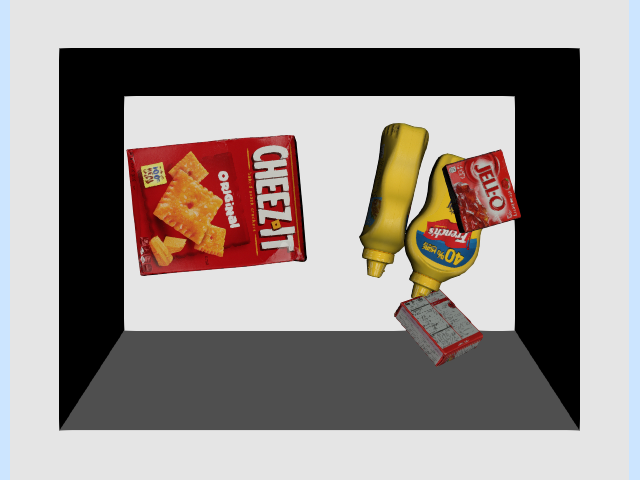

In [6]:
img

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

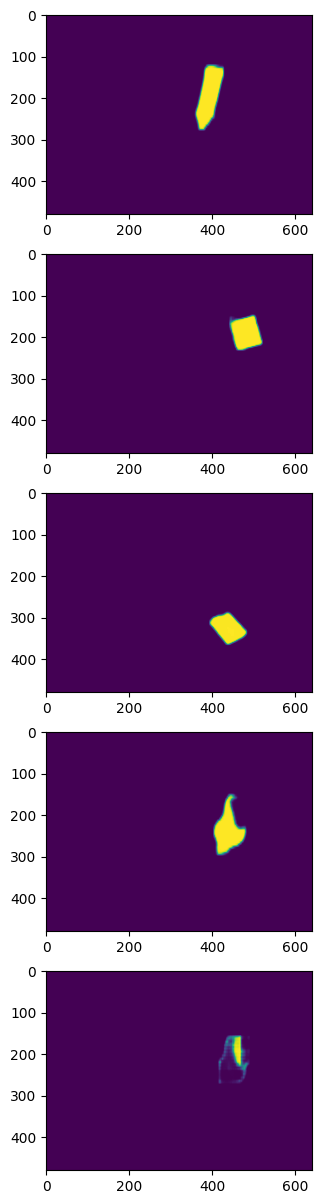

In [7]:
N = prediction[0]["masks"].shape[0]
fig, ax = plt.subplots(N, 1, figsize=(15, 15))
for n in range(prediction[0]["masks"].shape[0]):
    ax[n].imshow(
        np.asarray(
            Image.fromarray(prediction[0]["masks"][n, 0].mul(255).byte().cpu().numpy())
        )
    )

# Plot the object detections

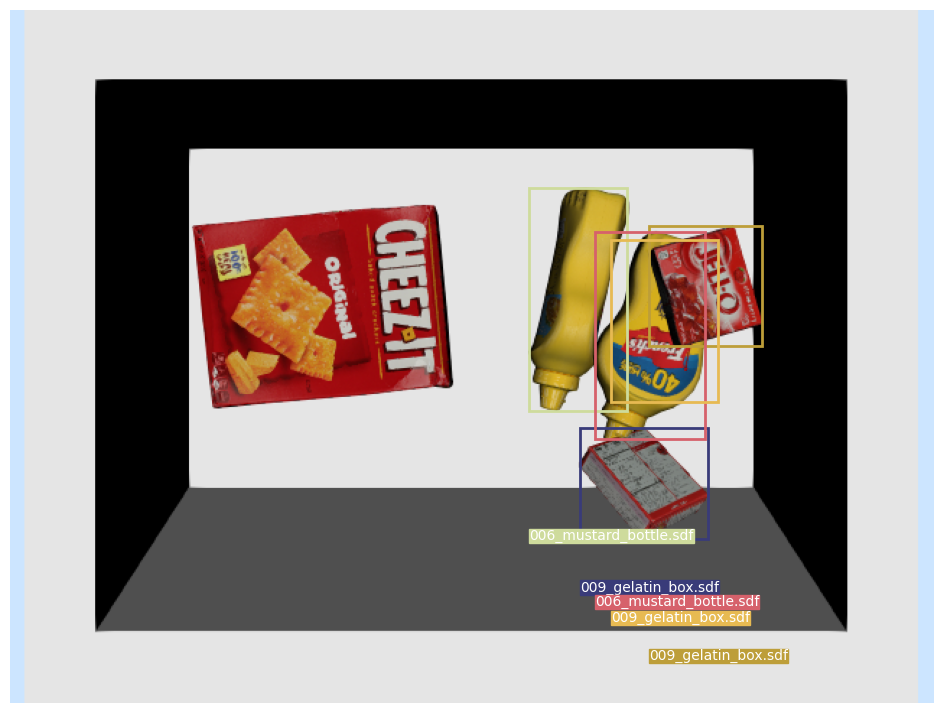

In [8]:
import random

import matplotlib.patches as patches


def plot_prediction():
    img_np = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)

    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    num_instances = prediction[0]["boxes"].shape[0]
    bbox_colors = random.sample(colors, num_instances)
    boxes = prediction[0]["boxes"].cpu().numpy()
    labels = prediction[0]["labels"].cpu().numpy()

    for i in range(num_instances):
        color = bbox_colors[i]
        bb = boxes[i, :]
        bbox = patches.Rectangle(
            (bb[0], bb[1]),
            bb[2] - bb[0],
            bb[3] - bb[1],
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(bbox)
        plt.text(
            bb[0],
            bb[0],
            s=ycb[labels[i]],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )
    plt.axis("off")


plot_prediction()

# Visualize the region proposals

Let's visualize some of the intermediate results of the networks.

TODO: would be very cool to put a slider on this so that we could slide through ALL of the boxes.  But my matplotlib non-interactive backend makes it too tricky!

Region proposals (drawing first 20 out of 1000)


<Figure size 640x480 with 0 Axes>

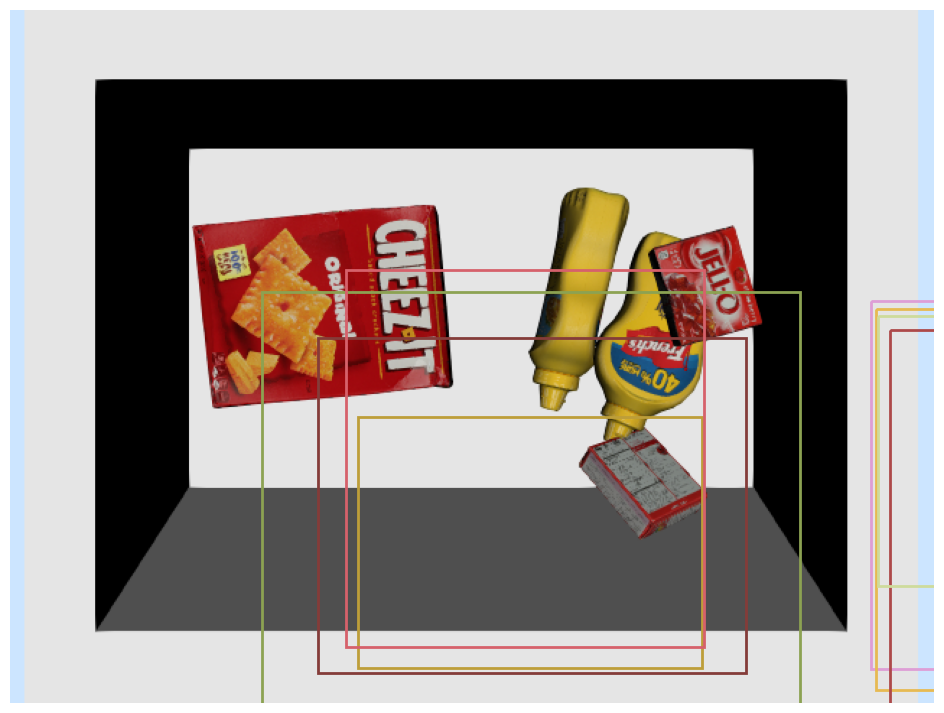

In [9]:
class Inspector:
    """A helper class from Kuni to be used for torch.nn.Module.register_forward_hook."""

    def __init__(self):
        self.x = None

    def hook(self, module, input, output):
        self.x = output


inspector = Inspector()
model.rpn.register_forward_hook(inspector.hook)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

rpn_values = inspector.x


img_np = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img_np)

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

num_to_draw = 20
bbox_colors = random.sample(colors, num_to_draw)
boxes = rpn_values[0][0].cpu().numpy()
print(f"Region proposals (drawing first {num_to_draw} out of {boxes.shape[0]})")

for i in range(num_to_draw):
    color = bbox_colors[i]
    bb = boxes[i, :]
    bbox = patches.Rectangle(
        (bb[0], bb[1]),
        bb[2] - bb[0],
        bb[3] - bb[1],
        linewidth=2,
        edgecolor=color,
        facecolor="none",
    )
    ax.add_patch(bbox)
plt.axis("off");

# Try a few more images

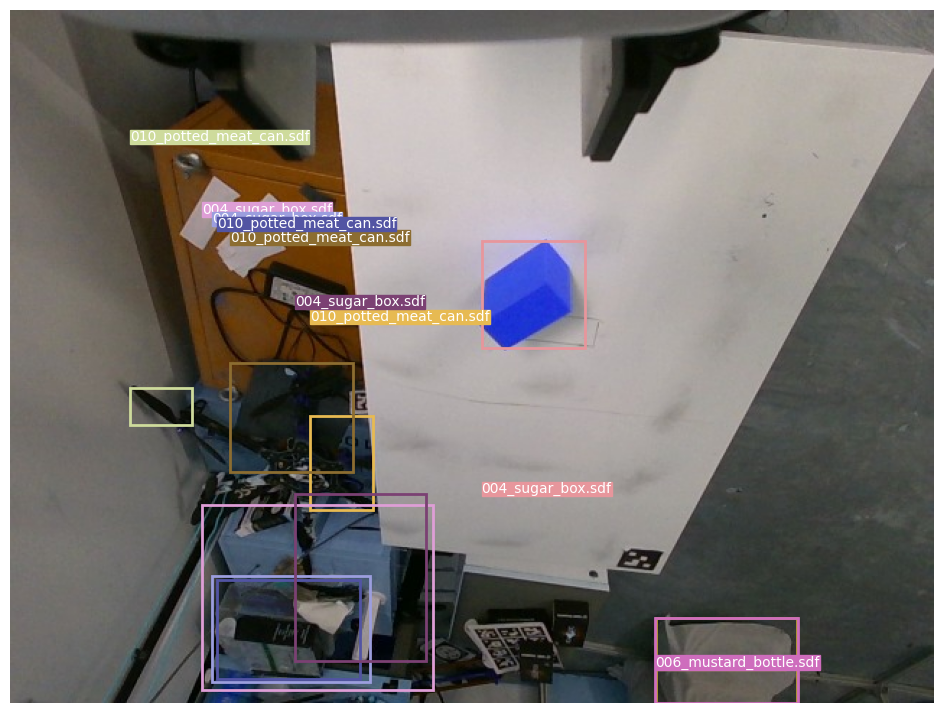

In [10]:
# pick one image from the test set (choose between 9950 and 9999)
# img = open_image(9985)

img = Image.open('img.jpeg').convert("RGB")
with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

plot_prediction()

In [21]:
print(prediction[0]['boxes'])

tensor([[207.3598, 280.8188, 251.1905, 345.6854],
        [152.1783, 243.7035, 237.2740, 319.5735],
        [ 82.4261, 261.1638, 125.8398, 286.8166],
        [447.0535, 420.7732, 544.8979, 480.0000],
        [132.8319, 342.5777, 292.8091, 470.7314],
        [446.5654, 420.4811, 545.4040, 479.2651],
        [139.1657, 391.2274, 248.9515, 465.2757],
        [142.7082, 394.1147, 241.9294, 463.0733],
        [196.7159, 334.8545, 287.3742, 450.3514],
        [326.1065, 159.8082, 397.5642, 233.2892]], device='cuda:0')


In [17]:
# print(prediction[0].keys())
# print(prediction[0]['labels'])
target_label = "004_sugar_box.sdf"

target_index = -1
# Get the corresponding index of the target label (if available)
for idx, label in enumerate(prediction[0]["labels"]):
    if label == target_label:  # Modify this check based on your label representation
        target_index = idx
        break
print(target_index)

0


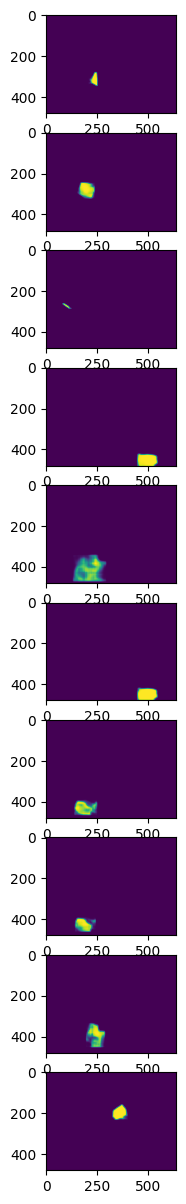

In [11]:
N = prediction[0]["masks"].shape[0]
fig, ax = plt.subplots(N, 1, figsize=(15, 15))
for n in range(prediction[0]["masks"].shape[0]):
    ax[n].imshow(
        np.asarray(
            Image.fromarray(prediction[0]["masks"][n, 0].mul(255).byte().cpu().numpy())
        )
    )